# [Titanic](https://www.kaggle.com/c/titanic)

### Celem tej lekcji  jest zrobienie predykcji, czy pasażer Titanica przeżyje... 
Pamiętasz historię o [Titanicu](https://www.youtube.com/watch?v=FSGeskFzE0s)? Spróbujemy zrobić prognozowanie.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from scikitplot.estimators import plot_learning_curve

from collections import defaultdict
import helper as h

import matplotlib.pyplot as plt
%matplotlib inline

## Wczytujemy dane

In [2]:
train = pd.read_csv('../input/titanic.train.csv')
train.shape

(891, 12)

## Sprawdzamy dane

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Uruchom kilka razy `.sample`, wtedy można zobaczyć więcej losowych rekordów (`CTRL` + `Enter` uruchomi komórkę, ale nie "przeskoczy" do następnej).

In [5]:
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
495,496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
648,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
278,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C
298,299,1,1,"Saalfeld, Mr. Adolphe",male,NaN,0,0,19988,30.5000,C106,S
609,610,1,1,"Shutes, Miss. Elizabeth W",female,40.0,0,0,PC 17582,153.4625,C125,S
318,319,1,1,"Wick, Miss. Mary Natalie",female,31.0,0,2,36928,164.8667,C7,S
484,485,1,1,"Bishop, Mr. Dickinson H",male,25.0,1,0,11967,91.0792,B49,C
367,368,1,3,"Moussa, Mrs. (Mantoura Boulos)",female,NaN,0,0,2626,7.2292,NaN,C


## Proste założenia na początek

Mamy binarną zmienną docelową - **Survived**.  
Metryką sukcesu jest **accuracy** (dokładność). Akurat takie było założenie z góry na Kaggle.

Na początek możemy założyć kilka prostych hipotez:
1. Kobiety mają większe szanse na przeżycie.
2. Osoby z pierwszej klasy mają większe szanse na przeżycie.

In [6]:
train.pivot_table(values=["Survived"], index=["Pclass","Sex"], aggfunc=np.mean)

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

## Basic Model

Budujemy trzy proste modele, bazując na cechach, jakie mamy.

In [7]:
def get_X_y(feats):
    X = train[ feats ].fillna(-1).values
    y = train['Survived'].values
    
    return X, y

X, y = get_X_y(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])

In [8]:
cross_val_score(DummyClassifier(random_state=2019), X, y, scoring='accuracy', cv=3).mean()

0.6161616161616161

In [9]:
cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=2019), X, y, scoring='accuracy', cv=3).mean()

0.6879910213243546

In [10]:
cross_val_score(RandomForestClassifier(max_depth=3, n_estimators=100, random_state=2019), X, y, scoring='accuracy', cv=3).mean()

0.7059483726150394

## Feature Engineering

Zacznijmy tworzyć nowe cechy. Na pierwszy ogień weźmiemy `title`, bo tam akurat można wyciągnąć np. tytuł: `Mr`, `Mrs` itd.

In [11]:
train['title'] = train['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
train['title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: title, dtype: int64

Jest kilka popularnych tytułów oraz kilka rzadkich przypadków. Np. `Capt`, czyli kapitan, był jeden itd. Spróbujmy zostawić tylko 6 najbardziej popularnych i resztę przypisać do "inne" (`other`).

In [12]:
top_titles = list(train['title'].value_counts().head(6).keys())

title_norm = defaultdict(lambda: 'other', dict(zip(top_titles, top_titles)))
train['title_norm'] = train['title'].map(title_norm)
train['title_norm'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
other      14
Dr          7
Rev         6
Name: title_norm, dtype: int64

Uruchamiamy `factorize`, czyli przypisywanie wartości numerycznej, dla `title_norm`.

In [13]:
#train['title_cat'] = train['title'].factorize()[0]
train['title_norm_cat'] = train['title_norm'].factorize()[0]

### Model + title_norm

In [14]:
X, y = get_X_y(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'title_norm_cat'])
cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=2019), X, y, scoring='accuracy', cv=3).mean()

0.8125701459034792

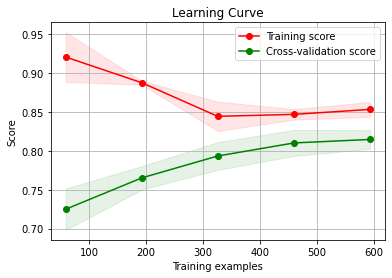

In [15]:
plot_learning_curve(DecisionTreeClassifier(max_depth=4, random_state=2019), X, y, cv=3);

Spora poprawa:
**0.7059** vs **0.8125**

## Age
Zbadajmy teraz średni wiek.

In [16]:
dict_mean_age_by_title = train.groupby('title_norm').agg(np.mean)['Age'].to_dict()
dict_mean_age_by_title

{'Dr': 42.0,
 'Master': 4.574166666666667,
 'Miss': 21.773972602739725,
 'Mr': 32.368090452261306,
 'Mrs': 35.898148148148145,
 'Rev': 43.166666666666664,
 'other': 42.214285714285715}

Już widać, że są pewne przedziały wiekowe. `Miss` ma średnio 21,7 lat, natomiast `Dr` średnio 42 lata, co brzmi dość sensownie. Można też sprawdzić medianę. Dosyć ciekawy jest również średni wiek `Master` - 4,5 roku.

In [17]:
dict_median_age_by_title = train.groupby('title_norm').agg(np.median)['Age'].to_dict()
dict_median_age_by_title

{'Dr': 46.5,
 'Master': 3.5,
 'Miss': 21.0,
 'Mr': 30.0,
 'Mrs': 35.0,
 'Rev': 46.5,
 'other': 42.5}

Utwórzmy nowe zmienne, w których przypiszemy te agregaty dla osób o danych tytułach.

In [18]:
train['age_mean'] = train.title_norm.map(dict_mean_age_by_title)
train['age_median'] = train.title_norm.map(dict_median_age_by_title)

In [19]:
X, y = get_X_y(['Pclass', 'title_norm_cat', 'SibSp', 'Parch', 'Fare', 'age_mean', 'age_median'])
cross_val_score(DecisionTreeClassifier(max_depth=4, random_state=2019), X, y, scoring='accuracy', cv=3).mean()

0.819304152637486

Trochę lepiej:
**0.8125** vs **0.8193**

## Family

Różne pomysły na temat rodziny.

In [20]:
# szacunek wielkości rodziny
train['family_size']   = train['SibSp'] + train['Parch'] + 1
train['family_single'] = train['family_size'] == 1
train['family_small']  = (train['family_size'] > 1) & (train['family_size'] < 5)
train['family_big']  = train['family_size'] > 4

# czy osoba jest pełnoletnia, czy nie
train['child'] = train['age_mean'] < 18
train['adult'] = train['age_mean'] >= 18

# czy osoba jest matką
def is_mother(row):
    if row['Sex'] == 'male': return False
    if row['title_norm_cat'] == 'miss': return False
    if row['age_mean'] < 18: return False
    
    return True

train['is_mother'] = train.apply(is_mother, axis=1)
print(train['is_mother'].value_counts())

X, y = get_X_y(['Pclass', 'title_norm_cat', 'SibSp', 'Parch', 'Fare', 'age_mean', 'age_median', 'family_size', 'family_single', 'family_small', 'family_big'])
cross_val_score(DecisionTreeClassifier(max_depth=4, random_state=2019), X, y, scoring='accuracy', cv=3).mean()

False    577
True     314
Name: is_mother, dtype: int64


0.8237934904601572

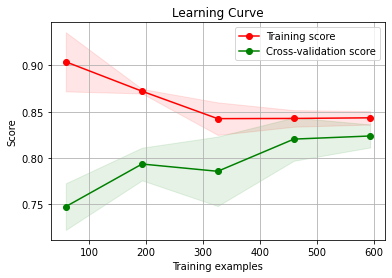

In [21]:
plot_learning_curve(DecisionTreeClassifier(max_depth=4, random_state=2019), X, y, cv=3);

Kolejna drobna poprawa:
**0.8193** vs **0.8237**

## Przydatne linki:
1. [Webinar - Titanic](https://www.youtube.com/watch?v=GvuxM3z4xU4)
2. [Klasyfikacja pasażerów Titanica](https://mateuszgrzyb.pl/klasyfikacja-pasazerow-titanica/)
3. [How to score 0.8134 in Titanic Kaggle Challenge](https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html)
4. [Kaggle Competition | Titanic Machine Learning from Disaster](http://nbviewer.jupyter.org/github/agconti/kaggle-titanic/blob/master/Titanic.ipynb)